## Followed this notebook: https://github.com/EmuKit/emukit/blob/main/notebooks/Emukit-tutorial-multi-fidelity.ipynb

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import yaml
import importlib.util
import random
random.seed(42)

import GPy
from emukit.multi_fidelity.kernels import LinearMultiFidelityKernel
from emukit.multi_fidelity.models import GPyLinearMultiFidelityModel
from emukit.model_wrappers.gpy_model_wrappers import GPyMultiOutputWrapper
from emukit.multi_fidelity.convert_lists_to_array import convert_x_list_to_array, convert_xy_lists_to_arrays

In [2]:
with open("../xenon/settings.yaml", "r") as f:
    config_file = yaml.safe_load(f)

version       = config_file["path_settings"]["version"]
path_out_cnp  = config_file["path_settings"]["path_out_cnp"]
path_out_mfgp = config_file["path_settings"]["path_out_mfgp"]
file_in=f'{path_out_cnp}/cnp_{version}_output_15epochs.csv'

In [3]:
# data processing/setup
np.random.seed(42)

if not os.path.exists(path_out_mfgp):
   os.makedirs(path_out_mfgp)

# Set parameter name/x_labels -> needs to be consistent with data input file
x_labels        = config_file["simulation_settings"]["theta_headers"]
y_label_cnp     = 'y_cnp'
y_err_label_cnp = 'y_cnp_err'
y_label_sim     = 'y_raw'

In [4]:
data=pd.read_csv(file_in)

LF_cnp_noise=np.mean(data.loc[(data['fidelity']==0.) & (data['iteration']==0)][y_err_label_cnp].to_numpy())
HF_cnp_noise=np.mean(data.loc[(data['fidelity']==1.) & (data['iteration']==0)][y_err_label_cnp].to_numpy())
LF_sim_noise=np.std(data.loc[(data['fidelity']==0.) & (data['iteration']==0)][y_label_sim].to_numpy())
HF_sim_noise=np.std(data.loc[(data['fidelity']==1.) & (data['iteration']==0)][y_label_sim].to_numpy())

# Get the filtered dataframe first
filtered_data = data.loc[(data['fidelity']==1.) & (data['iteration']==0)]

# # Get unique combinations of x_label values to select diverse training points
# unique_x_combinations = filtered_data[x_labels].drop_duplicates()

# # Select up to 3 diverse training points based on different x_label combinations
# if len(unique_x_combinations) >= 3:
#     # Select 3 points with most diverse x values
#     # Get min, max, and a middle point for each x dimension
#     x_data = unique_x_combinations.values
    
#     # Find points with min/max values for first dimension (water_shielding_mm)
#     min_x1_idx = np.argmin(x_data[:, 0])
#     max_x1_idx = np.argmax(x_data[:, 0])
    
#     # Find a point with different x2 value (veto_thickness_mm) that's not min/max x1
#     remaining_indices = [i for i in range(len(x_data)) if i not in [min_x1_idx, max_x1_idx]]
#     if remaining_indices:
#         # Select point with most different x2 value from the min/max x1 points
#         x1_values = x_data[[min_x1_idx, max_x1_idx], 1]
#         mid_x2_idx = remaining_indices[np.argmax([abs(x_data[i, 1] - np.mean(x1_values)) for i in remaining_indices])]
#     else:
#         mid_x2_idx = min_x1_idx if min_x1_idx != max_x1_idx else 0
    
#     selected_combinations = unique_x_combinations.iloc[[min_x1_idx, max_x1_idx, mid_x2_idx]]
# else:
#     # If fewer than 3 unique combinations, use all available
#     selected_combinations = unique_x_combinations

# # Find the indices in filtered_data that match these selected combinations
# train_indices = []
# for _, combo in selected_combinations.iterrows():
#     # Find first occurrence of this combination in filtered_data
#     mask = (filtered_data[x_labels[0]] == combo[x_labels[0]]) & (filtered_data[x_labels[1]] == combo[x_labels[1]])
#     matching_indices = filtered_data[mask].index.tolist()
#     if matching_indices:
#         train_indices.append(matching_indices[0])  # Take first occurrence

# test_indices = filtered_data.index.difference(train_indices)



# filtered_data = data.loc[(data['fidelity']==1.) & (data['iteration']==0)]

# unique_x_combinations = filtered_data[x_labels].drop_duplicates().values

# combination_1 = []
# combination_2 = []
# combination_3 = []

# samples_with_combination_1 = filtered_data.loc[filtered_data[x_labels].values==unique_x_combinations[0]]
# combination_1.extend(list(set(samples_with_combination_1.index.to_list())))
# samples_with_combination_2 = filtered_data.loc[filtered_data[x_labels].values==unique_x_combinations[1]]
# combination_2.extend(list(set(samples_with_combination_2.index.to_list())))
# samples_with_combination_3 = filtered_data.loc[filtered_data[x_labels].values==unique_x_combinations[2]]
# combination_3.extend(list(set(samples_with_combination_3.index.to_list())))

# random.shuffle(combination_1)
# random.shuffle(combination_2)
# random.shuffle(combination_3)

# combination_1_70 = combination_1[:int(len(combination_1) // (10/9))]
# combination_1_30 = combination_1[int(len(combination_1) // (10/9)):]
# combination_2_70 = combination_2[:int(len(combination_2) // (10/9))]
# combination_2_30 = combination_2[int(len(combination_2) // (10/9)):]
# combination_3_70 = combination_3[:int(len(combination_3) // (10/9))]
# combination_3_30 = combination_3[int(len(combination_3) // (10/9)):]


# # Extract training data
# x_train_hf_sim = filtered_data.loc[train_indices][x_labels].to_numpy().tolist()
# y_train_hf_sim = filtered_data.loc[train_indices][y_label_sim].to_numpy().tolist()

# # Extract testing data
# x_test_hf_sim = filtered_data.loc[test_indices][x_labels].to_numpy().tolist()
# y_test_hf_sim = filtered_data.loc[test_indices][y_label_sim].to_numpy().tolist()

# Approach 2
# Extract training data
x_train_hf_sim = filtered_data[x_labels].to_numpy().tolist()
y_train_hf_sim = filtered_data[y_label_sim].to_numpy().tolist()

# # Extract testing data
# x_test_hf_sim = filtered_data[x_labels].to_numpy().tolist()
# y_test_hf_sim = filtered_data[y_label_sim].to_numpy().tolist()

# ## Approach 3
# # Extract training data
# x_train_hf_sim = filtered_data.loc[combination_1_70][x_labels].to_numpy().tolist()
# x_train_hf_sim.extend(filtered_data.loc[combination_2_70][x_labels].to_numpy().tolist())
# x_train_hf_sim.extend(filtered_data.loc[combination_3_70][x_labels].to_numpy().tolist())
# y_train_hf_sim = filtered_data.loc[combination_1_70][y_label_sim].to_numpy().tolist()
# y_train_hf_sim.extend(filtered_data.loc[combination_2_70][y_label_sim].to_numpy().tolist())
# y_train_hf_sim.extend(filtered_data.loc[combination_3_70][y_label_sim].to_numpy().tolist())
# combined_train_hf_sim = list(zip(x_train_hf_sim, y_train_hf_sim))
# random.shuffle(combined_train_hf_sim)
# x_train_hf_sim, y_train_hf_sim = zip(*combined_train_hf_sim)
# x_train_hf_sim = list(x_train_hf_sim)
# y_train_hf_sim = list(y_train_hf_sim)

# # Extract testing data
# x_test_hf_sim = filtered_data.loc[combination_1_30][x_labels].to_numpy().tolist()
# x_test_hf_sim.extend(filtered_data.loc[combination_2_30][x_labels].to_numpy().tolist())
# x_test_hf_sim.extend(filtered_data.loc[combination_3_30][x_labels].to_numpy().tolist())
# y_test_hf_sim = filtered_data.loc[combination_1_30][y_label_sim].to_numpy().tolist()
# y_test_hf_sim.extend(filtered_data.loc[combination_2_30][y_label_sim].to_numpy().tolist())
# y_test_hf_sim.extend(filtered_data.loc[combination_3_30][y_label_sim].to_numpy().tolist())
# combined_test_hf_sim = list(zip(x_test_hf_sim, y_test_hf_sim))
# random.shuffle(combined_test_hf_sim)
# x_test_hf_sim, y_test_hf_sim = zip(*combined_test_hf_sim)
# x_test_hf_sim = list(x_test_hf_sim)
# y_test_hf_sim = list(y_test_hf_sim)

x_train_lf_cnp = data.loc[(data['fidelity']==0.) & (data['iteration']==0)][x_labels].to_numpy().tolist()
y_train_lf_cnp = data.loc[(data['fidelity']==0.) & (data['iteration']==0)][y_label_cnp].to_numpy().tolist()


# trainings_data = {"lf": [x_train_lf_cnp,y_train_lf_cnp], "hf": [x_train_hf_sim,y_train_hf_sim]}#, } "mf": [x_train_hf_cnp,y_train_hf_cnp]
# noise = {"lf": LF_cnp_noise, "hf": HF_sim_noise *0.001}#, "hf": 0.0}  # why were mf and hf noise originally set to 0?
# noise = {"lf": 1.7e-6, "hf": 1.7e-6}
trainings_data = {"lf": [x_train_lf_cnp,y_train_lf_cnp], "hf": [x_train_hf_sim,y_train_hf_sim]}
noise = {"lf": LF_cnp_noise, "hf": HF_sim_noise *0.001}

In [5]:
fidelities = list(trainings_data.keys())
nfidelities = len(fidelities)

In [6]:
x_train = []
y_train = []
for fidelity in fidelities:
    x_tmp=np.atleast_2d(trainings_data[fidelity][0])
    y_tmp=np.atleast_2d(trainings_data[fidelity][1]).T
    x_train.append(x_tmp)
    y_train.append(y_tmp)

X_train, Y_train = convert_xy_lists_to_arrays(x_train, y_train)

In [7]:
num_fidelities = 2  # just lf and hf for now
kernels = [GPy.kern.Matern32(input_dim=X_train[0].shape[0] - 1), GPy.kern.Matern32(input_dim=X_train[0].shape[0] - 1)]  # since there are two theta parameters, input_dim is 2
# kernels = [GPy.kern.RBF(input_dim=X_train[0].shape[0] - 1), GPy.kern.RBF(input_dim=X_train[0].shape[0] - 1)]

linear_mf_kernel = LinearMultiFidelityKernel(kernels)
gpy_linear_mf_model = GPyLinearMultiFidelityModel(X_train, Y_train, linear_mf_kernel, n_fidelities = num_fidelities)

# set noise
gpy_linear_mf_model.mixed_noise.Gaussian_noise.fix(noise['lf'])  # lf noise
gpy_linear_mf_model.mixed_noise.Gaussian_noise_1.fix(noise['hf'])  # mf/hf noise

array([0])

In [8]:
# SET KERNEL HYPERPARAMETER BOUNDS
# Low-fidelity kernel (Mat32)
gpy_linear_mf_model['multifidelity.Mat32.variance'].constrain_bounded(1e-6, 1e2) # 2nd originally 1e2 --> 1.0
gpy_linear_mf_model['multifidelity.Mat32.lengthscale'].constrain_bounded(1e-2, 1e3) # 2nd originally 1e3 --> 1e2

# High-fidelity kernel (Mat32_1) 
gpy_linear_mf_model['multifidelity.Mat32_1.variance'].constrain_bounded(1e-6, 1e2)
gpy_linear_mf_model['multifidelity.Mat32_1.lengthscale'].constrain_bounded(1e-2, 1e3)

# # Low-fidelity kernel (RBF)
# gpy_linear_mf_model['multifidelity.rbf.variance'].constrain_bounded(1e-6, 1e2)
# gpy_linear_mf_model['multifidelity.rbf.lengthscale'].constrain_bounded(1e-2, 1e3)

# # High-fidelity kernel (RBF_1) 
# gpy_linear_mf_model['multifidelity.rbf_1.variance'].constrain_bounded(1e-6, 1e2)
# gpy_linear_mf_model['multifidelity.rbf_1.lengthscale'].constrain_bounded(1e-2, 1e3)

# Scale parameter (correlation between fidelities)
gpy_linear_mf_model['multifidelity.scale'].constrain_bounded(1e-3, 1e2) # --> 1e1 

# If you can unfix noise, increase it slightly
if hasattr(gpy_linear_mf_model.mixed_noise.Gaussian_noise, 'unfix'):
    gpy_linear_mf_model.mixed_noise.Gaussian_noise.unfix()
    gpy_linear_mf_model.mixed_noise.Gaussian_noise_1.unfix()
    
    # Set to 1.2x your original noise values with some bounds
    gpy_linear_mf_model.mixed_noise.Gaussian_noise.constrain_bounded(
        noise['lf'] * 0.15, noise['lf'] * 1.85)
    gpy_linear_mf_model.mixed_noise.Gaussian_noise_1.constrain_bounded(
        noise['hf'] * 0.15, noise['hf'] * 1.85) # 0.99, 1.01; 0.20, 1.80

reconstraining parameters gp.multifidelity.Mat32.variance
reconstraining parameters gp.multifidelity.Mat32.lengthscale
reconstraining parameters gp.multifidelity.Mat32_1.variance
reconstraining parameters gp.multifidelity.Mat32_1.lengthscale
reconstraining parameters gp.mixed_noise.Gaussian_noise
reconstraining parameters gp.mixed_noise.Gaussian_noise_1


In [9]:
'''# More aggressive bounds that encourage higher uncertainty
gpy_linear_mf_model['multifidelity.Mat32.variance'].constrain_bounded(1e-5, 1e3)
gpy_linear_mf_model['multifidelity.Mat32_1.variance'].constrain_bounded(1e-5, 1e3)
gpy_linear_mf_model['multifidelity.Mat32.lengthscale'].constrain_bounded(1e-4, 1e2)
gpy_linear_mf_model['multifidelity.Mat32_1.lengthscale'].constrain_bounded(1e-4, 1e2)

# Allow the scale parameter more freedom
gpy_linear_mf_model['multifidelity.scale'].constrain_bounded(1e-2, 1e2)

# If you can unfix noise, increase it slightly
if hasattr(gpy_linear_mf_model.mixed_noise.Gaussian_noise, 'unfix'):
    gpy_linear_mf_model.mixed_noise.Gaussian_noise.unfix()
    gpy_linear_mf_model.mixed_noise.Gaussian_noise_1.unfix()
    
    # Set to 1.2x your original noise values with some bounds
    gpy_linear_mf_model.mixed_noise.Gaussian_noise.constrain_bounded(
        noise['lf'] * 0.85, noise['lf'] * 1.15)
    gpy_linear_mf_model.mixed_noise.Gaussian_noise_1.constrain_bounded(
        noise['hf'] * 0.85, noise['hf'] * 1.15)'''

"# More aggressive bounds that encourage higher uncertainty\ngpy_linear_mf_model['multifidelity.Mat32.variance'].constrain_bounded(1e-5, 1e3)\ngpy_linear_mf_model['multifidelity.Mat32_1.variance'].constrain_bounded(1e-5, 1e3)\ngpy_linear_mf_model['multifidelity.Mat32.lengthscale'].constrain_bounded(1e-4, 1e2)\ngpy_linear_mf_model['multifidelity.Mat32_1.lengthscale'].constrain_bounded(1e-4, 1e2)\n\n# Allow the scale parameter more freedom\ngpy_linear_mf_model['multifidelity.scale'].constrain_bounded(1e-2, 1e2)\n\n# If you can unfix noise, increase it slightly\nif hasattr(gpy_linear_mf_model.mixed_noise.Gaussian_noise, 'unfix'):\n    gpy_linear_mf_model.mixed_noise.Gaussian_noise.unfix()\n    gpy_linear_mf_model.mixed_noise.Gaussian_noise_1.unfix()\n\n    # Set to 1.2x your original noise values with some bounds\n    gpy_linear_mf_model.mixed_noise.Gaussian_noise.constrain_bounded(\n        noise['lf'] * 0.85, noise['lf'] * 1.15)\n    gpy_linear_mf_model.mixed_noise.Gaussian_noise_1.cons

In [10]:
## Wrap the model using the given 'GPyMultiOutputWrapper'
lin_mf_model = GPyMultiOutputWrapper(gpy_linear_mf_model, num_fidelities, n_optimization_restarts=10, verbose_optimization=True)

## Fit the model
lin_mf_model.optimize()

Optimization restart 1/10, f = -4830.831569304086
Optimization restart 2/10, f = -4830.318537801468
KeyboardInterrupt caught, calling on_optimization_end() to round things up


 /home/tidmad/miniconda3/envs/coherent/lib/python3.12/site-packages/paramz/model.py:119: SyntaxWarning:invalid escape sequence '\*'
 /home/tidmad/miniconda3/envs/coherent/lib/python3.12/site-packages/GPy/core/gp.py:285: SyntaxWarning:invalid escape sequence '\m'
 /home/tidmad/miniconda3/envs/coherent/lib/python3.12/site-packages/GPy/core/gp.py:291: SyntaxWarning:invalid escape sequence '\i'
 /home/tidmad/miniconda3/envs/coherent/lib/python3.12/site-packages/GPy/core/gp.py:701: SyntaxWarning:invalid escape sequence '\m'
 /home/tidmad/miniconda3/envs/coherent/lib/python3.12/site-packages/GPy/core/gp.py:717: SyntaxWarning:invalid escape sequence '\m'
 /home/tidmad/miniconda3/envs/coherent/lib/python3.12/site-packages/paramz/core/parameter_core.py:302: SyntaxWarning:invalid escape sequence '\d'


KeyboardInterrupt: 

In [ ]:
import importlib
import sys

if 'mfgp_visualizations' in sys.modules:
    del sys.modules['mfgp_visualizations']

# Import the automated analysis pipeline
from mfgp_visualizations import MFGPAnalyzer, explore_predictions

print("MFGPAnalyzer imported successfully")
print("All analysis results will be saved to the output folder")

MFGPAnalyzer imported successfully
All analysis results will be saved to the output folder


In [ ]:
# Initialize the automated analyzer
# All plots and results will be saved to path_out_mfgp
analyzer = MFGPAnalyzer(
    mf_model=lin_mf_model,
    x_labels=x_labels,
    y_label_sim=y_label_sim,
    output_dir=path_out_mfgp  # This ensures all results are saved to the configured output folder
)

print("MFGPAnalyzer initialized successfully")
print(f"Output directory: {analyzer.output_dir}")
print(f"Parameter labels: {analyzer.x_labels}")
print(f"Target variable: {analyzer.y_label_sim}")
print("All plots and analysis results will be automatically saved")

MFGPAnalyzer initialized:
  Output directory: ../xenon/out/mfgp
  Parameter labels: ['scint_x', 'scint_y']
  Target variable: y_raw
MFGPAnalyzer initialized successfully
Output directory: ../xenon/out/mfgp
Parameter labels: ['scint_x', 'scint_y']
Target variable: y_raw
All plots and analysis results will be automatically saved


AUTOMATED MFGP ANALYSIS PIPELINE
Output directory: ../xenon/out/mfgp

1. Loading and processing CSV files...
Processing: ../xenon/out/cnp/cnp_v30.0_output_validation_15epochs.csv
  Found 33 unique theta combinations

2. Generating predictions for all theta combinations...

Generating predictions for cnp_v30.0_output_validation_15epochs.csv
  Theta (42.0, 24.0): mean=0.000176, std=0.000144
  Theta (0.0, 39.0): mean=0.000481, std=0.000530
  Theta (12.0, 39.0): mean=0.000508, std=0.000407
  Theta (21.0, 33.0): mean=0.000428, std=0.000266
  Theta (42.0, 18.0): mean=0.000037, std=0.000168
  Theta (21.0, 0.0): mean=-0.000099, std=0.000345
  Theta (33.0, 18.0): mean=0.000086, std=0.000142
  Theta (21.0, 24.0): mean=0.000249, std=0.000206
  Theta (12.0, 33.0): mean=0.000416, std=0.000366
  Theta (21.0, 18.0): mean=0.000133, std=0.000192
  Theta (33.0, 12.0): mean=-0.000027, std=0.000181
  Theta (33.0, 33.0): mean=0.000435, std=0.000163
  Theta (12.0, 24.0): mean=0.000266, std=0.000319
  Theta 

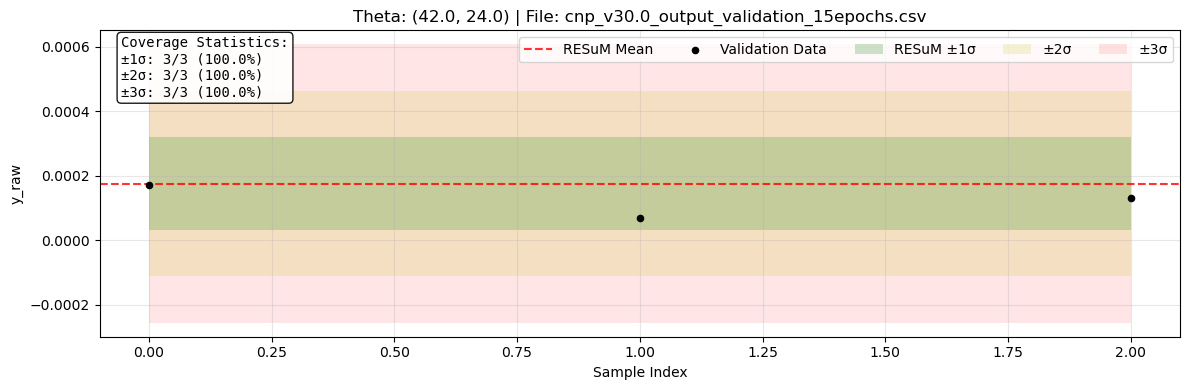

    Coverage statistics for Theta (42.0, 24.0):
    ±1σ: 3/3 (100.0%)
    ±2σ: 3/3 (100.0%)
    ±3σ: 3/3 (100.0%)
  Theta: (0.0, 39.0)
    Saved: ../xenon/out/mfgp/uncertainty_bands_cnp_v30.0_output_validation_15epochs_theta_0.0_39.0.png


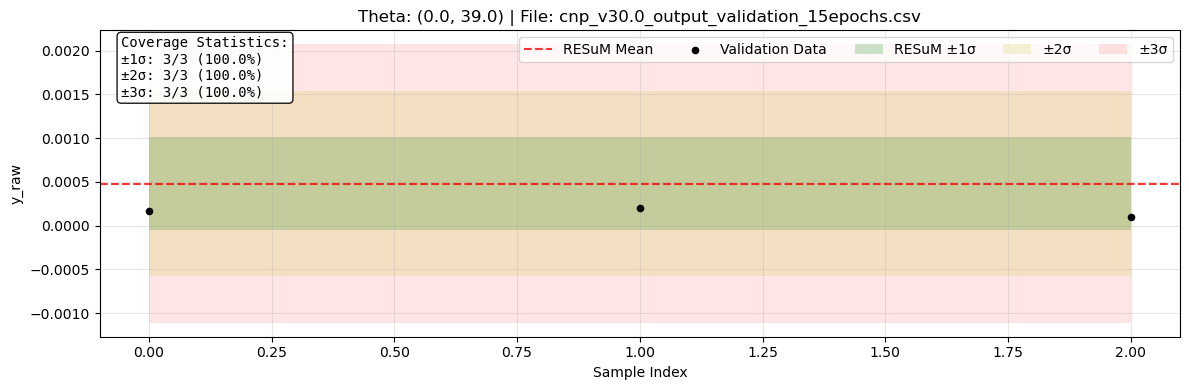

    Coverage statistics for Theta (0.0, 39.0):
    ±1σ: 3/3 (100.0%)
    ±2σ: 3/3 (100.0%)
    ±3σ: 3/3 (100.0%)
  Theta: (12.0, 39.0)
    Saved: ../xenon/out/mfgp/uncertainty_bands_cnp_v30.0_output_validation_15epochs_theta_12.0_39.0.png


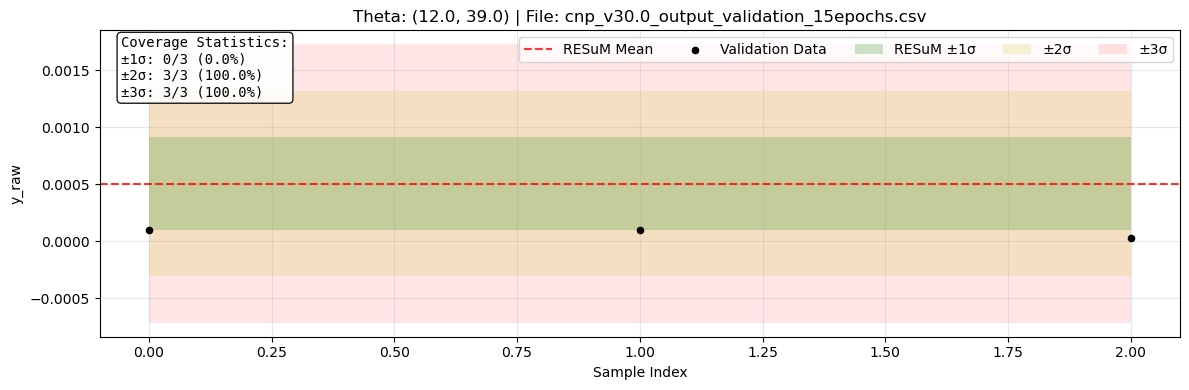

    Coverage statistics for Theta (12.0, 39.0):
    ±1σ: 0/3 (0.0%)
    ±2σ: 3/3 (100.0%)
    ±3σ: 3/3 (100.0%)
  Theta: (21.0, 33.0)
    Saved: ../xenon/out/mfgp/uncertainty_bands_cnp_v30.0_output_validation_15epochs_theta_21.0_33.0.png


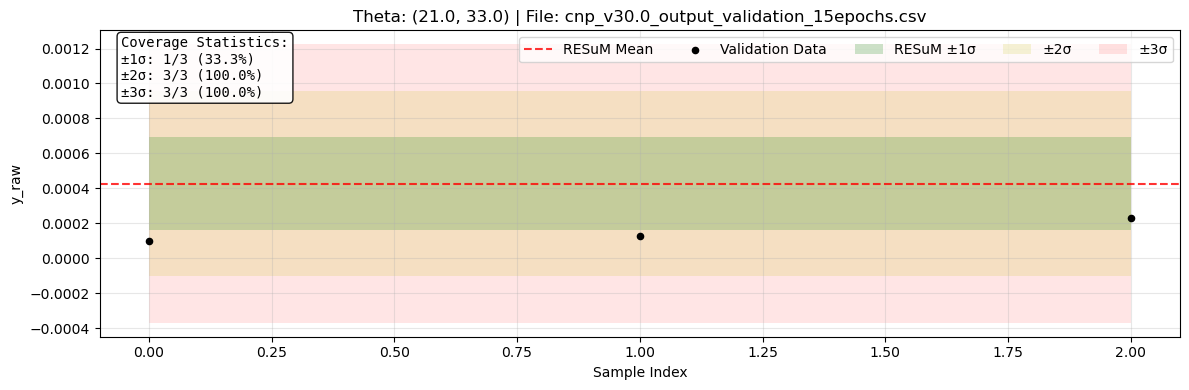

    Coverage statistics for Theta (21.0, 33.0):
    ±1σ: 1/3 (33.3%)
    ±2σ: 3/3 (100.0%)
    ±3σ: 3/3 (100.0%)
  Theta: (42.0, 18.0)
    Saved: ../xenon/out/mfgp/uncertainty_bands_cnp_v30.0_output_validation_15epochs_theta_42.0_18.0.png


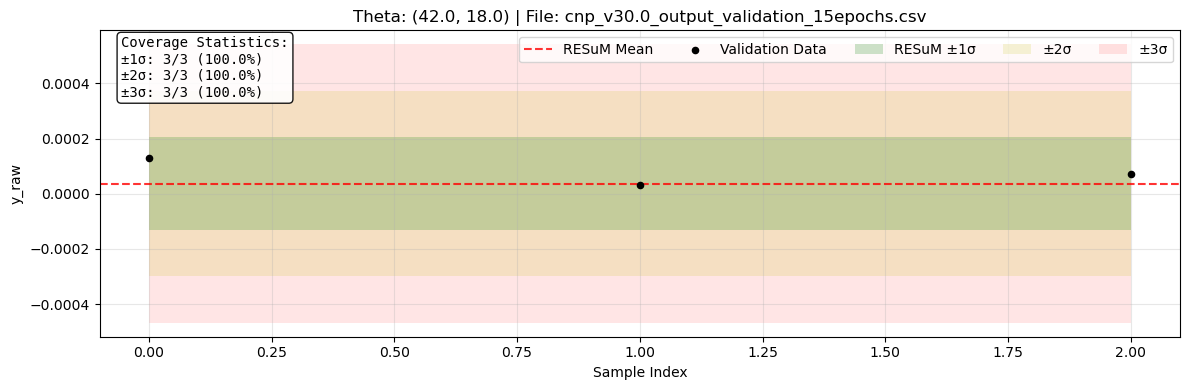

    Coverage statistics for Theta (42.0, 18.0):
    ±1σ: 3/3 (100.0%)
    ±2σ: 3/3 (100.0%)
    ±3σ: 3/3 (100.0%)
  Theta: (21.0, 0.0)
    Saved: ../xenon/out/mfgp/uncertainty_bands_cnp_v30.0_output_validation_15epochs_theta_21.0_0.0.png


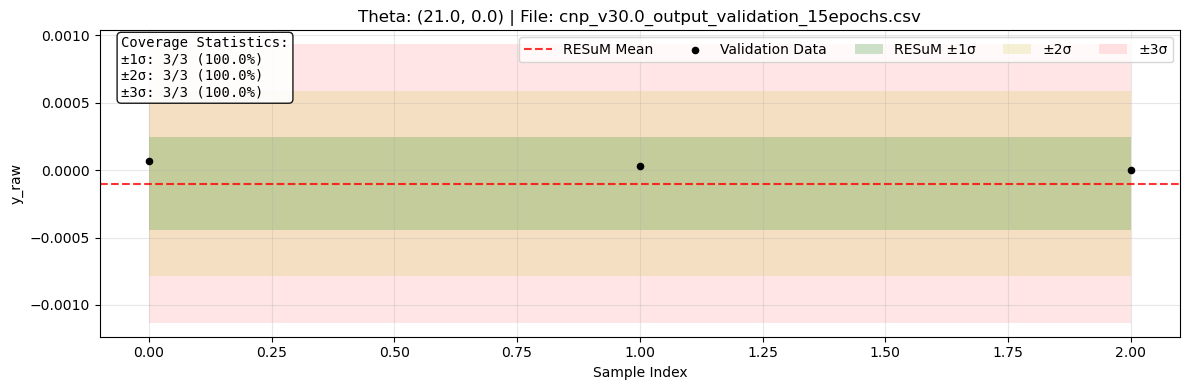

    Coverage statistics for Theta (21.0, 0.0):
    ±1σ: 3/3 (100.0%)
    ±2σ: 3/3 (100.0%)
    ±3σ: 3/3 (100.0%)
  Theta: (33.0, 18.0)
    Saved: ../xenon/out/mfgp/uncertainty_bands_cnp_v30.0_output_validation_15epochs_theta_33.0_18.0.png


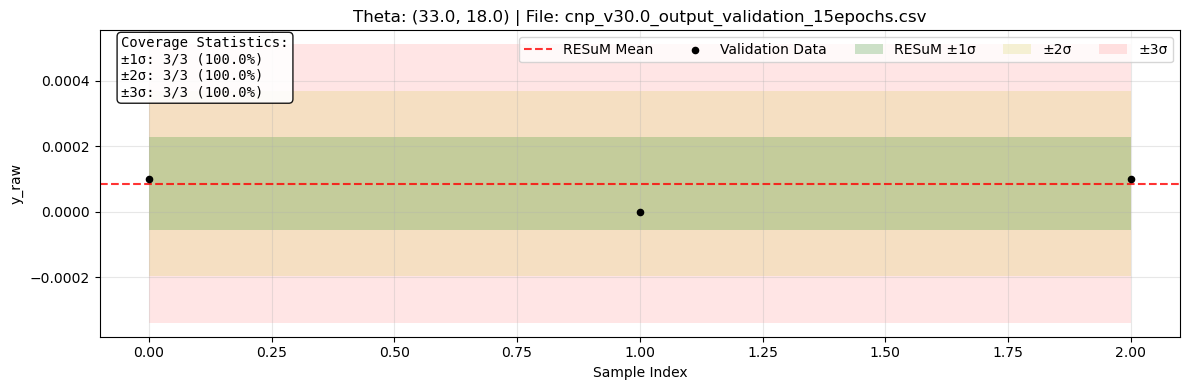

    Coverage statistics for Theta (33.0, 18.0):
    ±1σ: 3/3 (100.0%)
    ±2σ: 3/3 (100.0%)
    ±3σ: 3/3 (100.0%)
  Theta: (21.0, 24.0)
    Saved: ../xenon/out/mfgp/uncertainty_bands_cnp_v30.0_output_validation_15epochs_theta_21.0_24.0.png


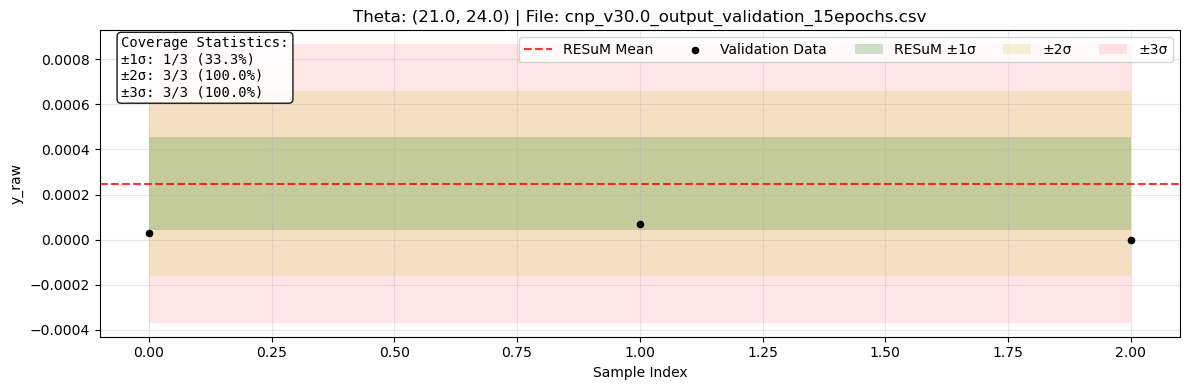

    Coverage statistics for Theta (21.0, 24.0):
    ±1σ: 1/3 (33.3%)
    ±2σ: 3/3 (100.0%)
    ±3σ: 3/3 (100.0%)
  Theta: (12.0, 33.0)
    Saved: ../xenon/out/mfgp/uncertainty_bands_cnp_v30.0_output_validation_15epochs_theta_12.0_33.0.png


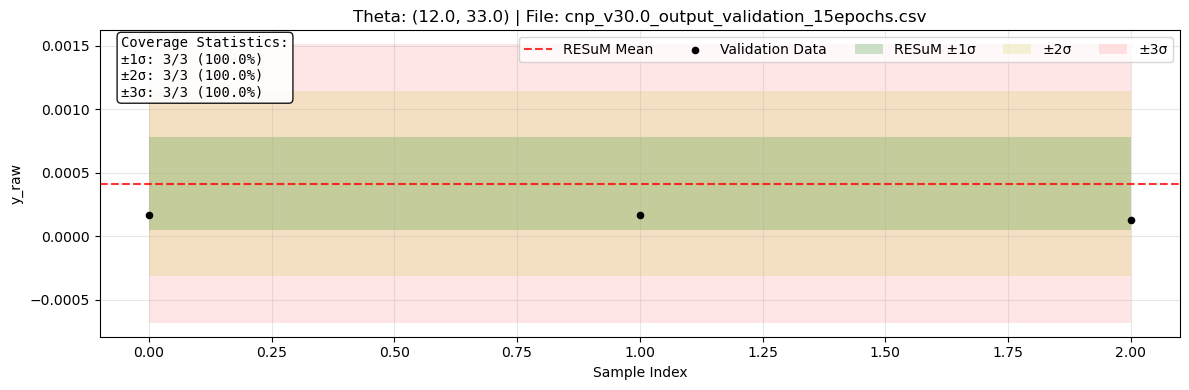

    Coverage statistics for Theta (12.0, 33.0):
    ±1σ: 3/3 (100.0%)
    ±2σ: 3/3 (100.0%)
    ±3σ: 3/3 (100.0%)
  Theta: (21.0, 18.0)
    Saved: ../xenon/out/mfgp/uncertainty_bands_cnp_v30.0_output_validation_15epochs_theta_21.0_18.0.png


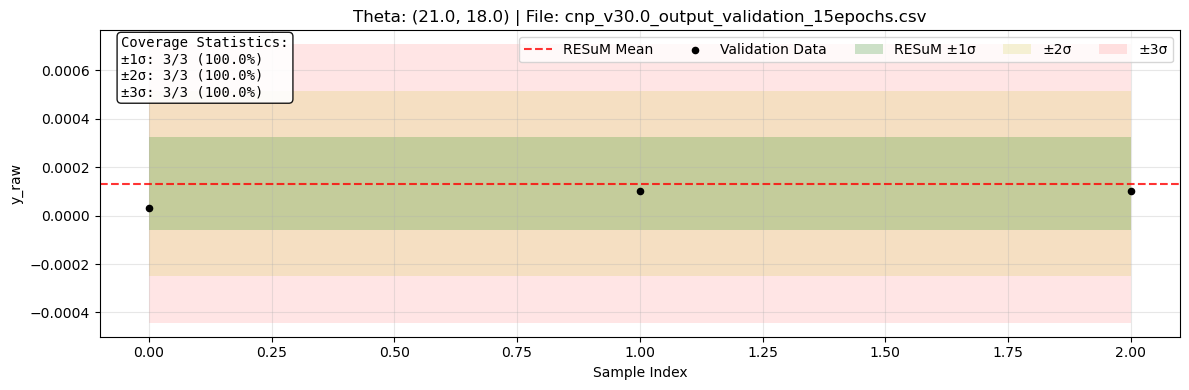

    Coverage statistics for Theta (21.0, 18.0):
    ±1σ: 3/3 (100.0%)
    ±2σ: 3/3 (100.0%)
    ±3σ: 3/3 (100.0%)
  Theta: (33.0, 12.0)
    Saved: ../xenon/out/mfgp/uncertainty_bands_cnp_v30.0_output_validation_15epochs_theta_33.0_12.0.png


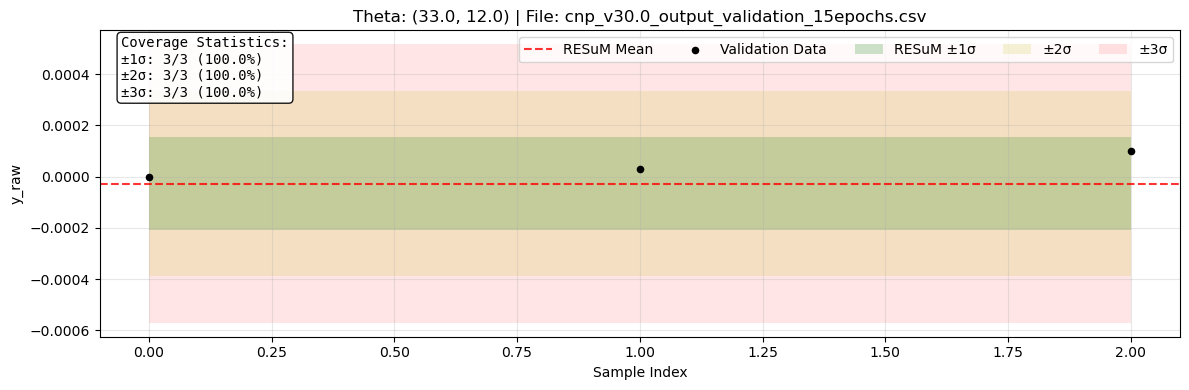

    Coverage statistics for Theta (33.0, 12.0):
    ±1σ: 3/3 (100.0%)
    ±2σ: 3/3 (100.0%)
    ±3σ: 3/3 (100.0%)
  Theta: (33.0, 33.0)
    Saved: ../xenon/out/mfgp/uncertainty_bands_cnp_v30.0_output_validation_15epochs_theta_33.0_33.0.png


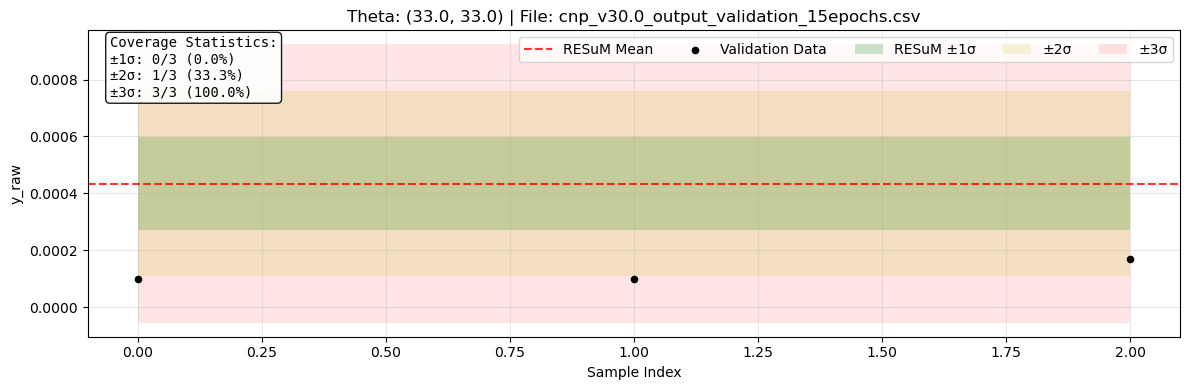

    Coverage statistics for Theta (33.0, 33.0):
    ±1σ: 0/3 (0.0%)
    ±2σ: 1/3 (33.3%)
    ±3σ: 3/3 (100.0%)
  Theta: (12.0, 24.0)
    Saved: ../xenon/out/mfgp/uncertainty_bands_cnp_v30.0_output_validation_15epochs_theta_12.0_24.0.png


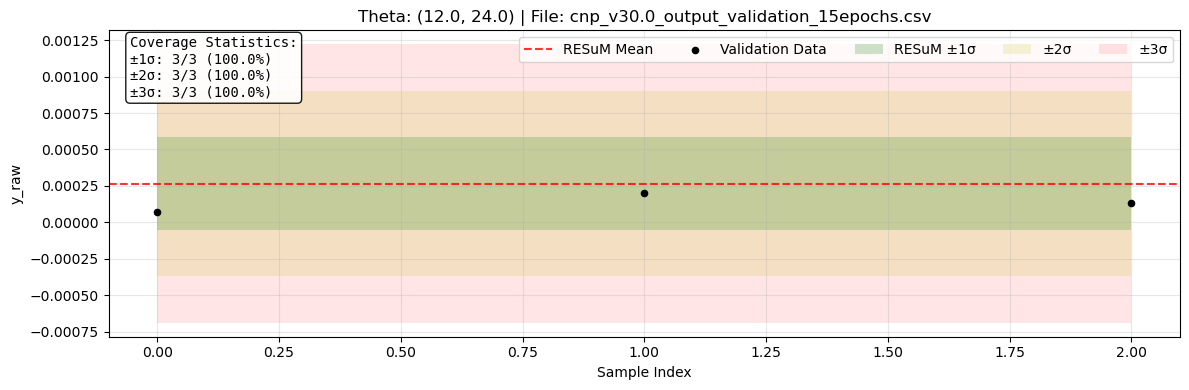

    Coverage statistics for Theta (12.0, 24.0):
    ±1σ: 3/3 (100.0%)
    ±2σ: 3/3 (100.0%)
    ±3σ: 3/3 (100.0%)
  Theta: (42.0, 39.0)
    Saved: ../xenon/out/mfgp/uncertainty_bands_cnp_v30.0_output_validation_15epochs_theta_42.0_39.0.png


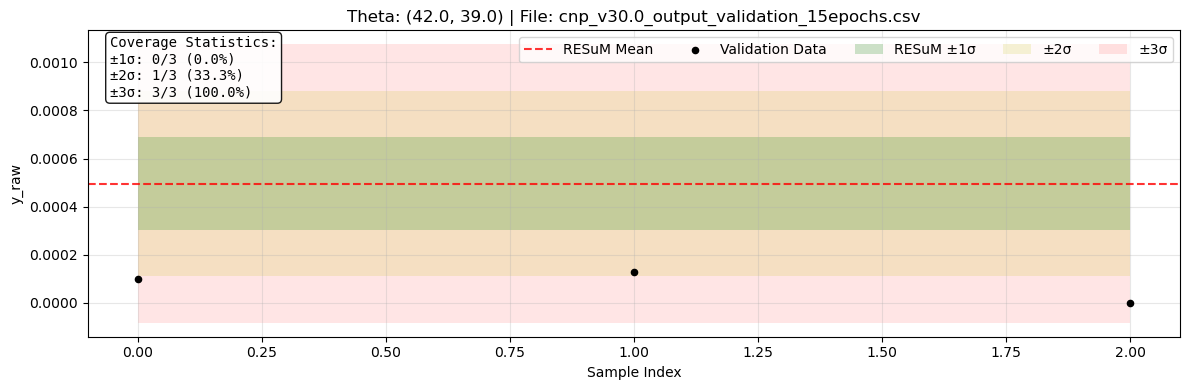

    Coverage statistics for Theta (42.0, 39.0):
    ±1σ: 0/3 (0.0%)
    ±2σ: 1/3 (33.3%)
    ±3σ: 3/3 (100.0%)
  Theta: (42.0, 0.0)
    Saved: ../xenon/out/mfgp/uncertainty_bands_cnp_v30.0_output_validation_15epochs_theta_42.0_0.0.png


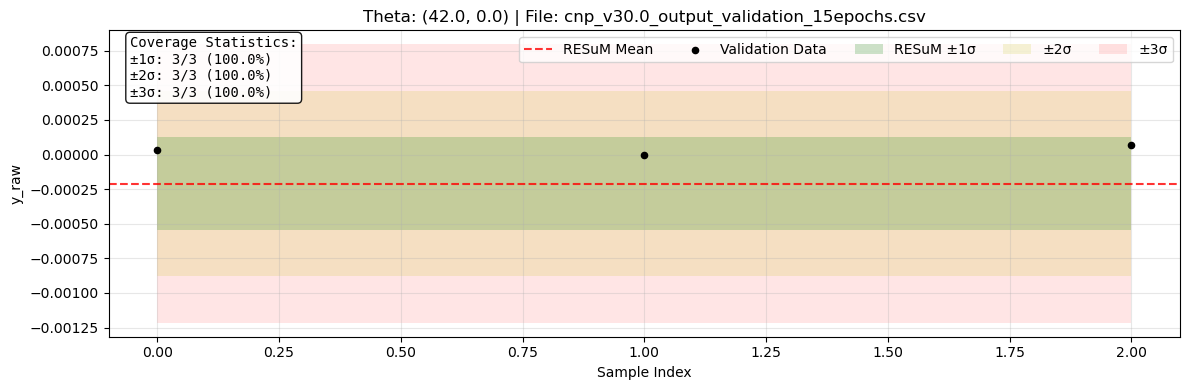

    Coverage statistics for Theta (42.0, 0.0):
    ±1σ: 3/3 (100.0%)
    ±2σ: 3/3 (100.0%)
    ±3σ: 3/3 (100.0%)
  Theta: (12.0, 0.0)
    Saved: ../xenon/out/mfgp/uncertainty_bands_cnp_v30.0_output_validation_15epochs_theta_12.0_0.0.png


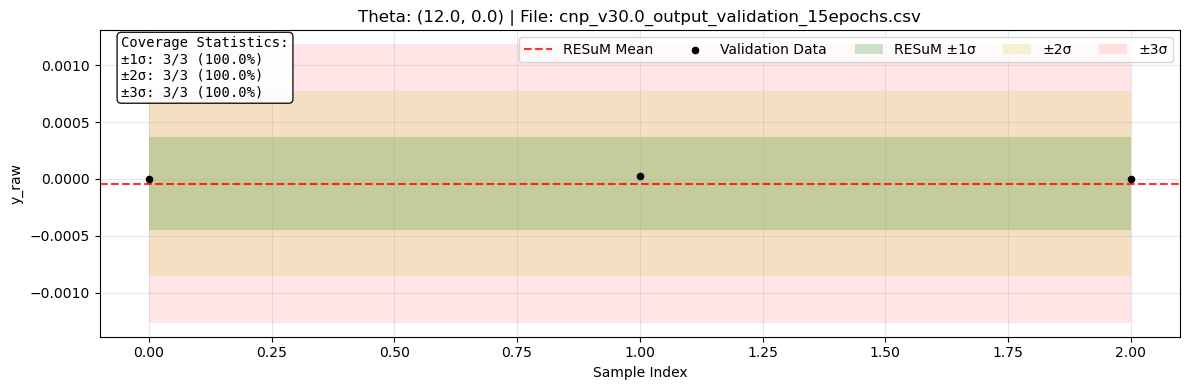

    Coverage statistics for Theta (12.0, 0.0):
    ±1σ: 3/3 (100.0%)
    ±2σ: 3/3 (100.0%)
    ±3σ: 3/3 (100.0%)
  Theta: (42.0, 12.0)
    Saved: ../xenon/out/mfgp/uncertainty_bands_cnp_v30.0_output_validation_15epochs_theta_42.0_12.0.png


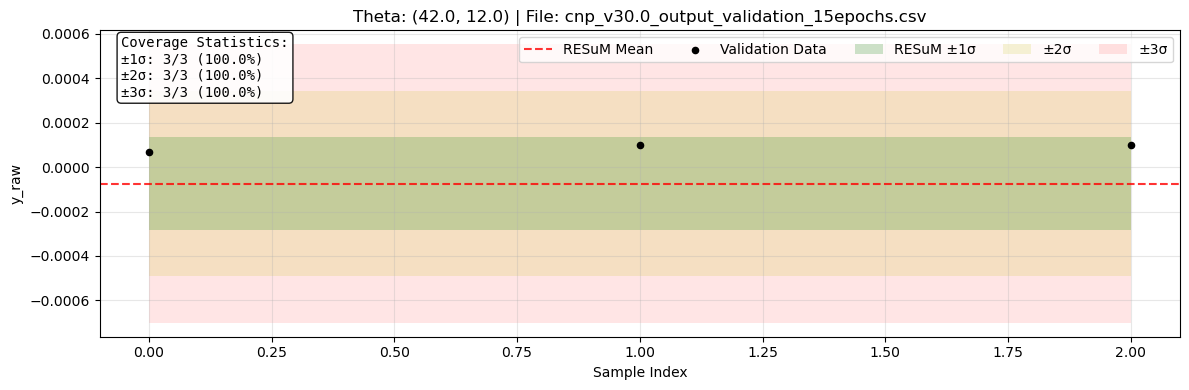

    Coverage statistics for Theta (42.0, 12.0):
    ±1σ: 3/3 (100.0%)
    ±2σ: 3/3 (100.0%)
    ±3σ: 3/3 (100.0%)
  Theta: (0.0, 0.0)
    Saved: ../xenon/out/mfgp/uncertainty_bands_cnp_v30.0_output_validation_15epochs_theta_0.0_0.0.png


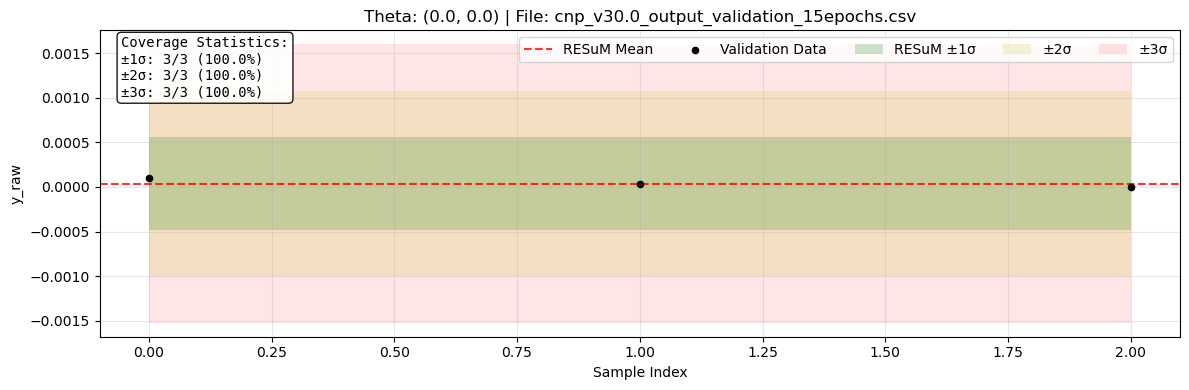

    Coverage statistics for Theta (0.0, 0.0):
    ±1σ: 3/3 (100.0%)
    ±2σ: 3/3 (100.0%)
    ±3σ: 3/3 (100.0%)
  Theta: (51.0, 12.0)
    Saved: ../xenon/out/mfgp/uncertainty_bands_cnp_v30.0_output_validation_15epochs_theta_51.0_12.0.png


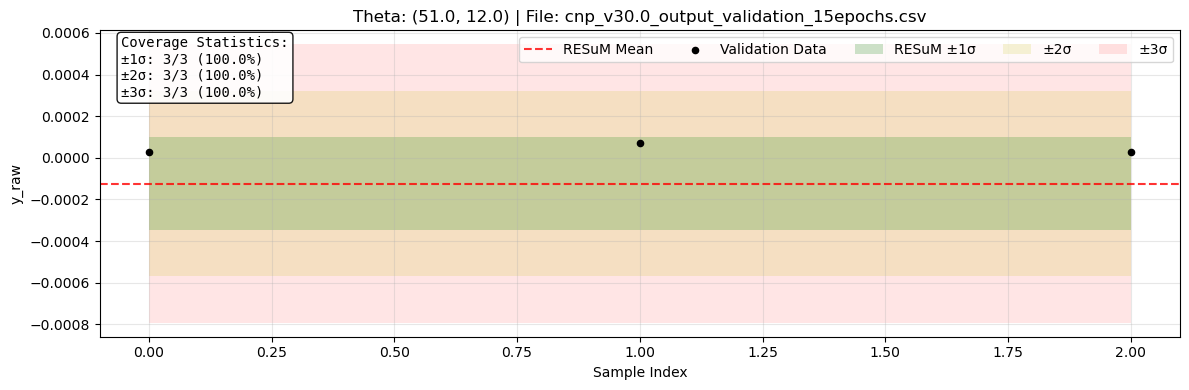

    Coverage statistics for Theta (51.0, 12.0):
    ±1σ: 3/3 (100.0%)
    ±2σ: 3/3 (100.0%)
    ±3σ: 3/3 (100.0%)
  Theta: (21.0, 12.0)
    Saved: ../xenon/out/mfgp/uncertainty_bands_cnp_v30.0_output_validation_15epochs_theta_21.0_12.0.png


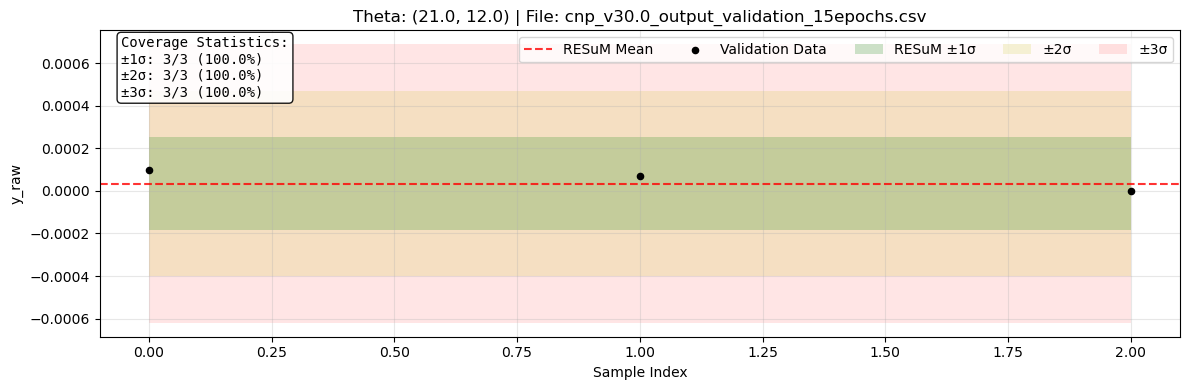

    Coverage statistics for Theta (21.0, 12.0):
    ±1σ: 3/3 (100.0%)
    ±2σ: 3/3 (100.0%)
    ±3σ: 3/3 (100.0%)
  Theta: (33.0, 0.0)
    Saved: ../xenon/out/mfgp/uncertainty_bands_cnp_v30.0_output_validation_15epochs_theta_33.0_0.0.png


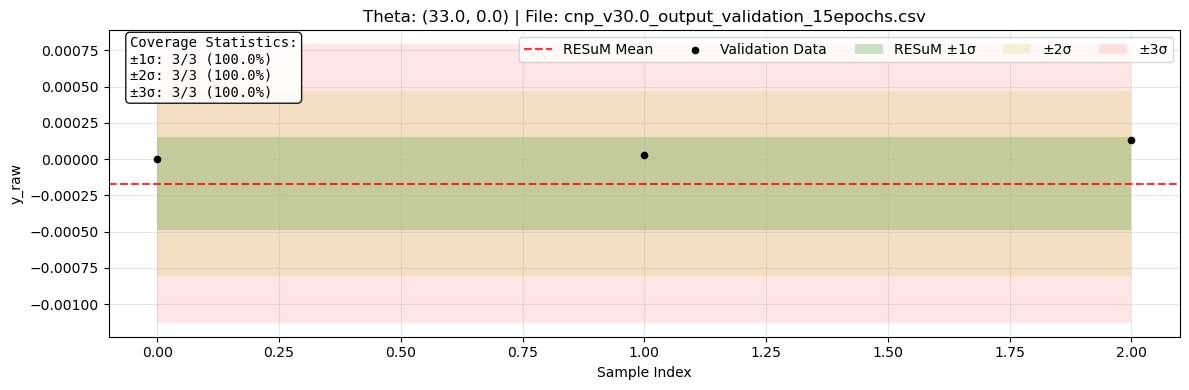

    Coverage statistics for Theta (33.0, 0.0):
    ±1σ: 3/3 (100.0%)
    ±2σ: 3/3 (100.0%)
    ±3σ: 3/3 (100.0%)
  Theta: (0.0, 18.0)
    Saved: ../xenon/out/mfgp/uncertainty_bands_cnp_v30.0_output_validation_15epochs_theta_0.0_18.0.png


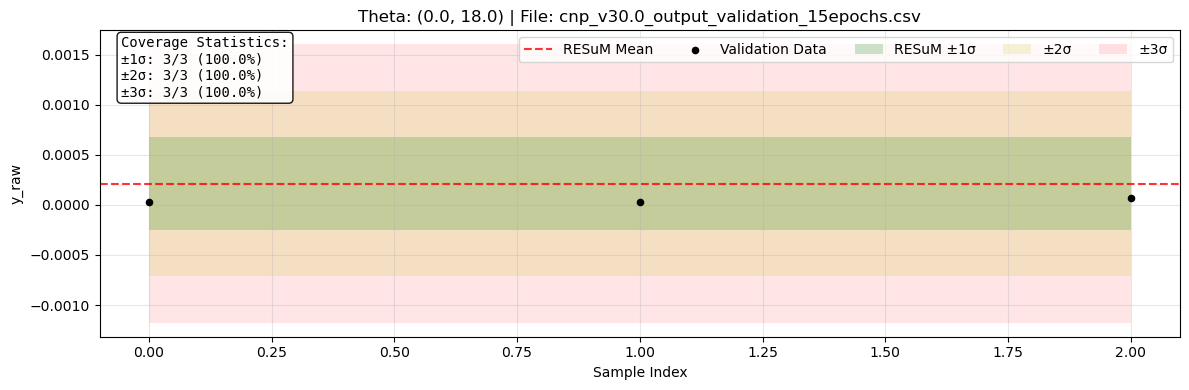

    Coverage statistics for Theta (0.0, 18.0):
    ±1σ: 3/3 (100.0%)
    ±2σ: 3/3 (100.0%)
    ±3σ: 3/3 (100.0%)
  Theta: (21.0, 39.0)
    Saved: ../xenon/out/mfgp/uncertainty_bands_cnp_v30.0_output_validation_15epochs_theta_21.0_39.0.png


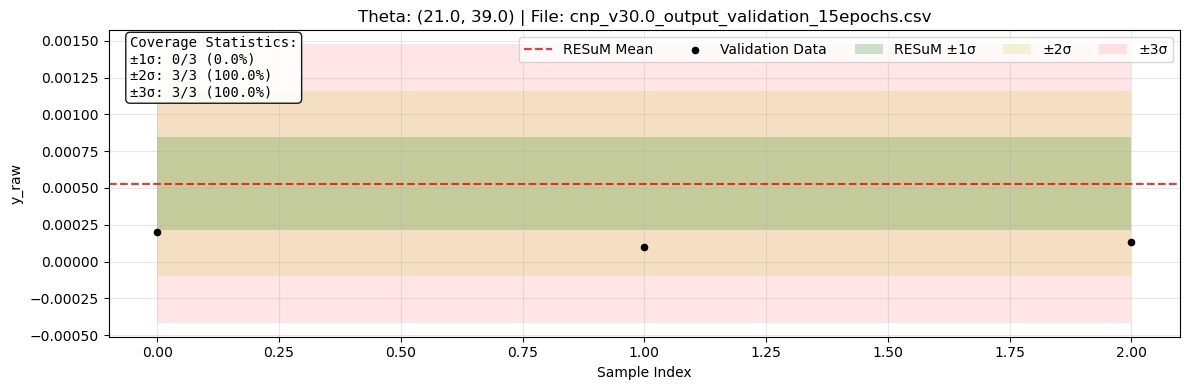

    Coverage statistics for Theta (21.0, 39.0):
    ±1σ: 0/3 (0.0%)
    ±2σ: 3/3 (100.0%)
    ±3σ: 3/3 (100.0%)
  Theta: (33.0, 24.0)
    Saved: ../xenon/out/mfgp/uncertainty_bands_cnp_v30.0_output_validation_15epochs_theta_33.0_24.0.png


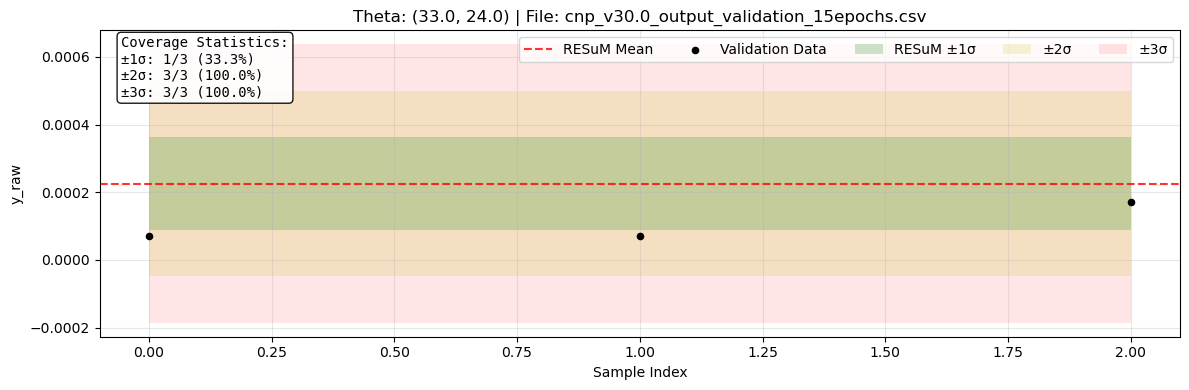

    Coverage statistics for Theta (33.0, 24.0):
    ±1σ: 1/3 (33.3%)
    ±2σ: 3/3 (100.0%)
    ±3σ: 3/3 (100.0%)
  Theta: (0.0, 24.0)
    Saved: ../xenon/out/mfgp/uncertainty_bands_cnp_v30.0_output_validation_15epochs_theta_0.0_24.0.png


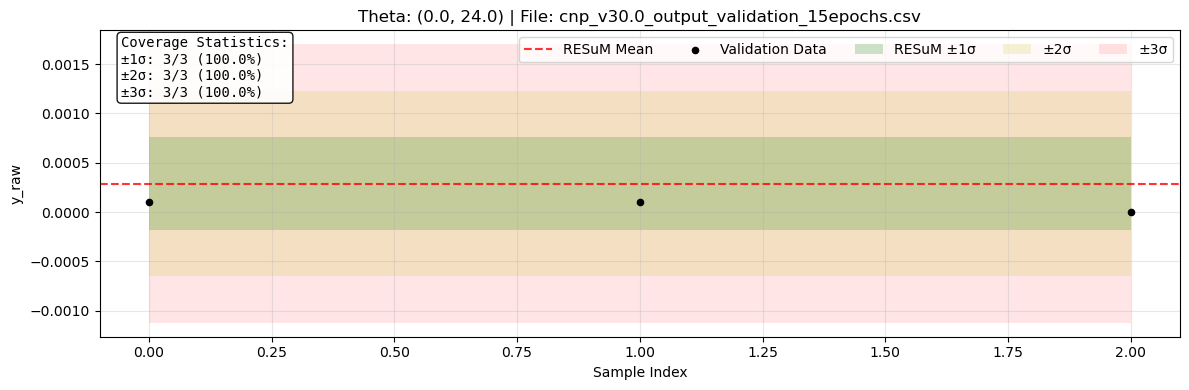

    Coverage statistics for Theta (0.0, 24.0):
    ±1σ: 3/3 (100.0%)
    ±2σ: 3/3 (100.0%)
    ±3σ: 3/3 (100.0%)
  Theta: (51.0, 0.0)
    Saved: ../xenon/out/mfgp/uncertainty_bands_cnp_v30.0_output_validation_15epochs_theta_51.0_0.0.png


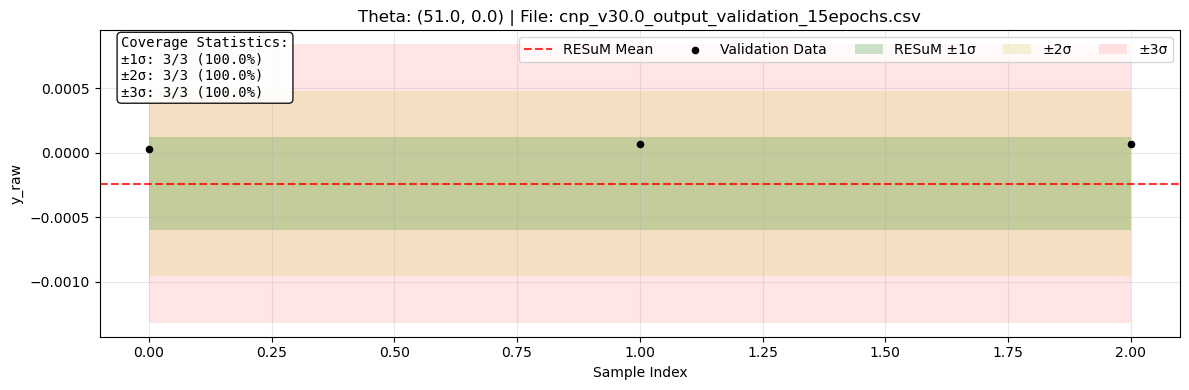

    Coverage statistics for Theta (51.0, 0.0):
    ±1σ: 3/3 (100.0%)
    ±2σ: 3/3 (100.0%)
    ±3σ: 3/3 (100.0%)
  Theta: (0.0, 33.0)
    Saved: ../xenon/out/mfgp/uncertainty_bands_cnp_v30.0_output_validation_15epochs_theta_0.0_33.0.png


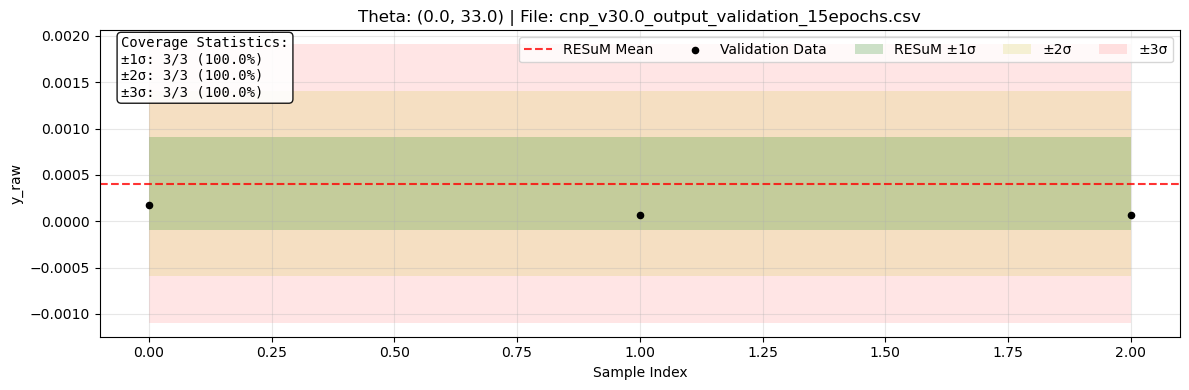

    Coverage statistics for Theta (0.0, 33.0):
    ±1σ: 3/3 (100.0%)
    ±2σ: 3/3 (100.0%)
    ±3σ: 3/3 (100.0%)
  Theta: (42.0, 33.0)
    Saved: ../xenon/out/mfgp/uncertainty_bands_cnp_v30.0_output_validation_15epochs_theta_42.0_33.0.png


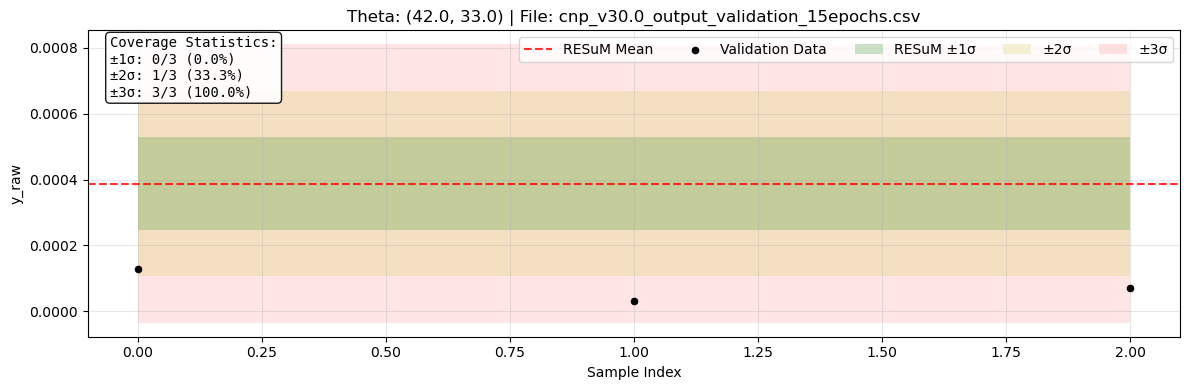

    Coverage statistics for Theta (42.0, 33.0):
    ±1σ: 0/3 (0.0%)
    ±2σ: 1/3 (33.3%)
    ±3σ: 3/3 (100.0%)
  Theta: (51.0, 18.0)
    Saved: ../xenon/out/mfgp/uncertainty_bands_cnp_v30.0_output_validation_15epochs_theta_51.0_18.0.png


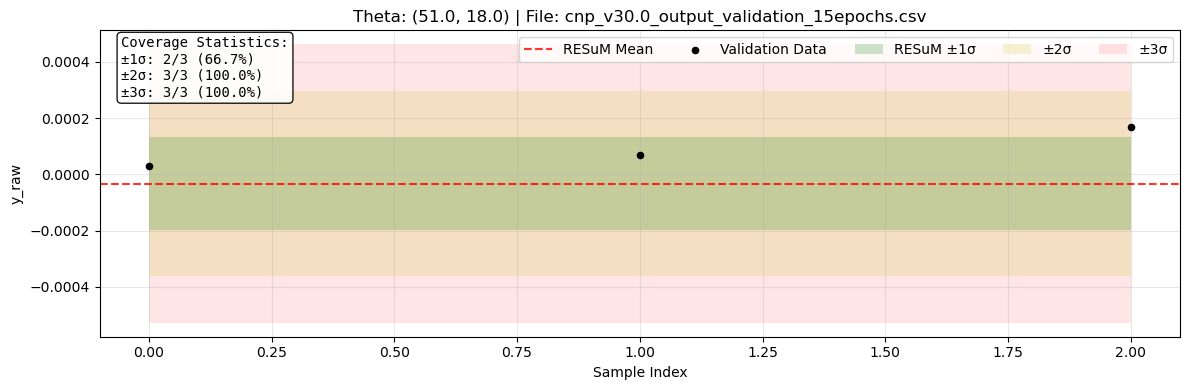

    Coverage statistics for Theta (51.0, 18.0):
    ±1σ: 2/3 (66.7%)
    ±2σ: 3/3 (100.0%)
    ±3σ: 3/3 (100.0%)
  Theta: (12.0, 18.0)
    Saved: ../xenon/out/mfgp/uncertainty_bands_cnp_v30.0_output_validation_15epochs_theta_12.0_18.0.png


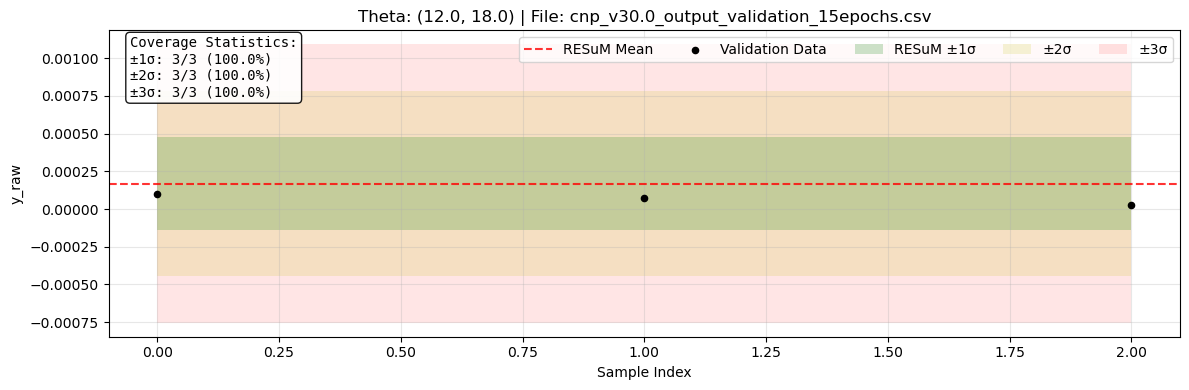

    Coverage statistics for Theta (12.0, 18.0):
    ±1σ: 3/3 (100.0%)
    ±2σ: 3/3 (100.0%)
    ±3σ: 3/3 (100.0%)
  Theta: (33.0, 39.0)
    Saved: ../xenon/out/mfgp/uncertainty_bands_cnp_v30.0_output_validation_15epochs_theta_33.0_39.0.png


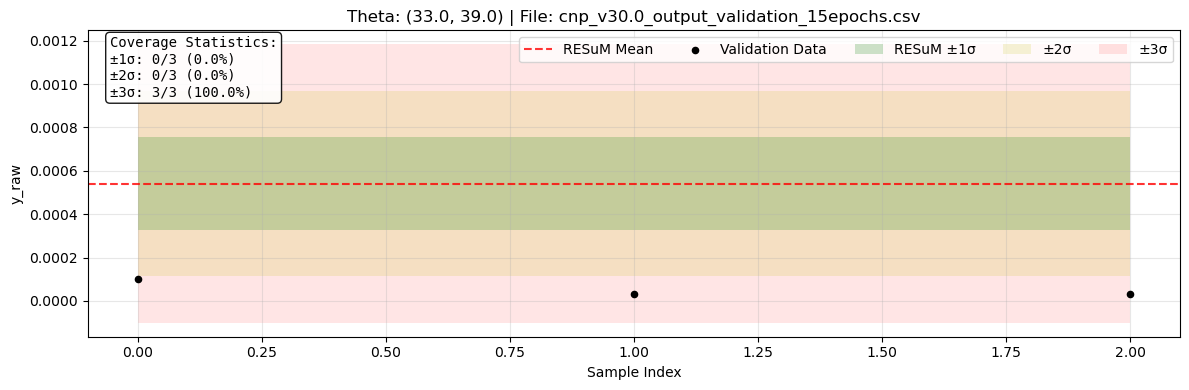

    Coverage statistics for Theta (33.0, 39.0):
    ±1σ: 0/3 (0.0%)
    ±2σ: 0/3 (0.0%)
    ±3σ: 3/3 (100.0%)
  Theta: (0.0, 12.0)
    Saved: ../xenon/out/mfgp/uncertainty_bands_cnp_v30.0_output_validation_15epochs_theta_0.0_12.0.png


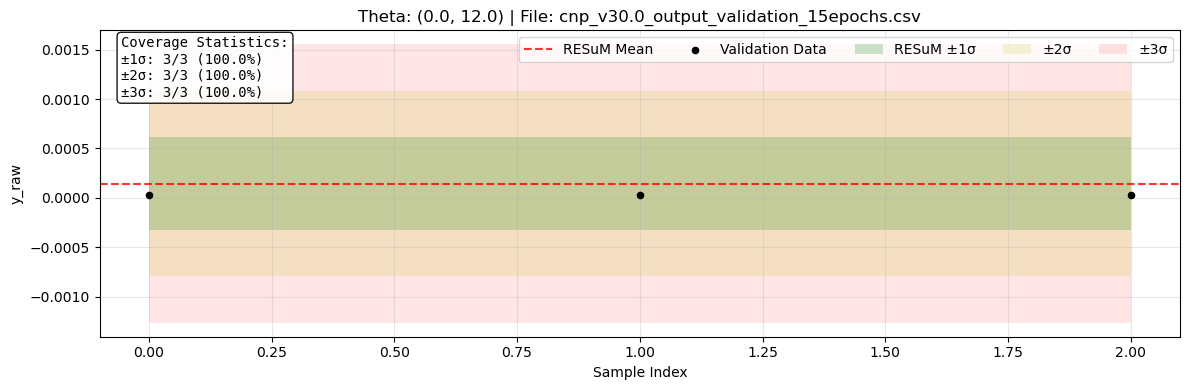

    Coverage statistics for Theta (0.0, 12.0):
    ±1σ: 3/3 (100.0%)
    ±2σ: 3/3 (100.0%)
    ±3σ: 3/3 (100.0%)
  Theta: (12.0, 12.0)
    Saved: ../xenon/out/mfgp/uncertainty_bands_cnp_v30.0_output_validation_15epochs_theta_12.0_12.0.png


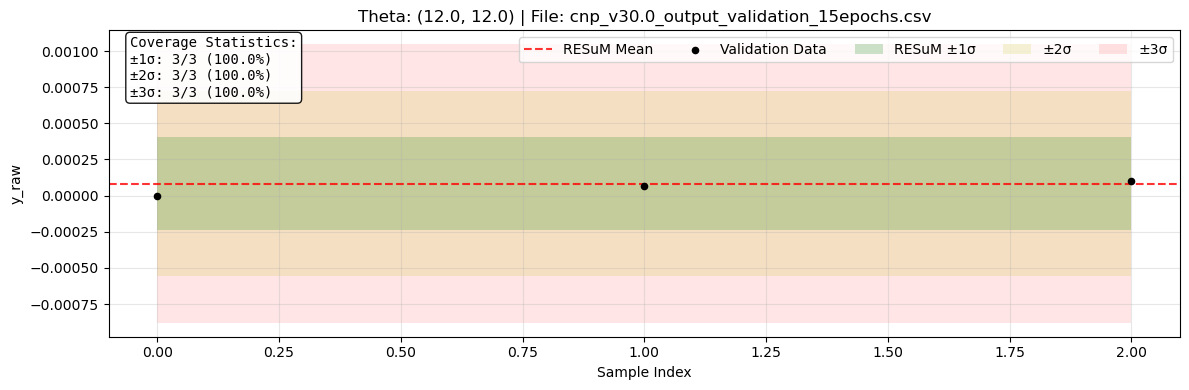

    Coverage statistics for Theta (12.0, 12.0):
    ±1σ: 3/3 (100.0%)
    ±2σ: 3/3 (100.0%)
    ±3σ: 3/3 (100.0%)

5. Creating coverage summary plots...
Coverage summary saved: ../xenon/out/mfgp/v30.0_coverage_summary.png


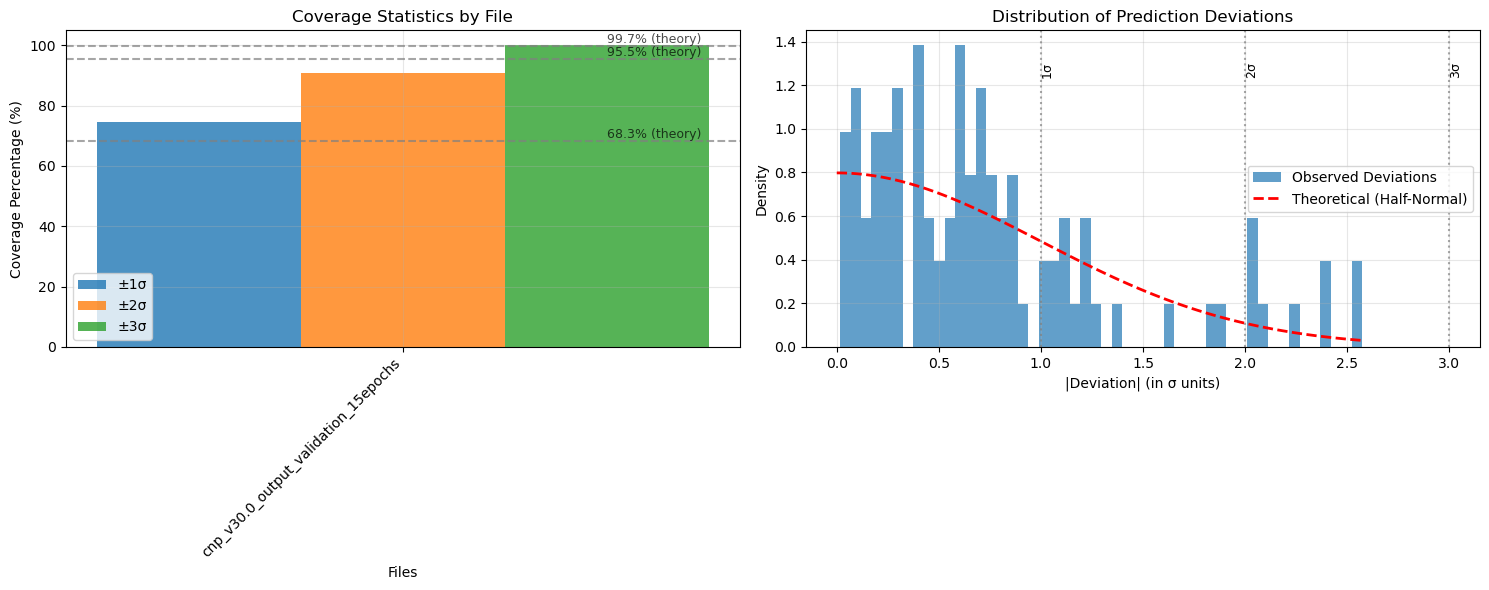


Overall Statistics (1 files, 99 total points):
±1σ: 74/99 (74.7%) | Theoretical: 68.3% | Diff: +6.5%
±2σ: 90/99 (90.9%) | Theoretical: 95.5% | Diff: -4.5%
±3σ: 99/99 (100.0%) | Theoretical: 99.7% | Diff: +0.3%

6. Creating enhanced contour analysis...
Enhanced contour analysis saved: ../xenon/out/mfgp/v30.0_enhanced_contour_analysis.png


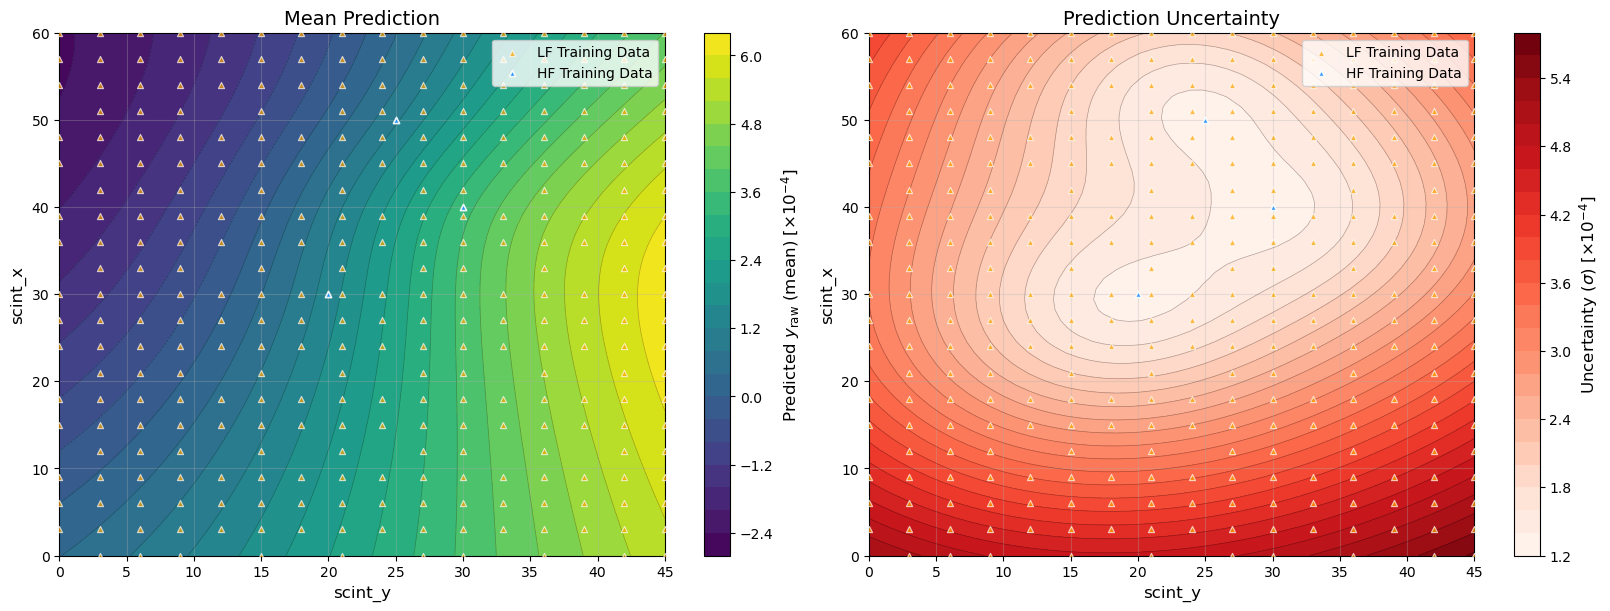


7. Creating prediction vs true value plots...
Prediction vs true (aggregated) plot saved: ../xenon/out/mfgp/predicted_vs_true_cnp_v30.0_output_validation_15epochs.png


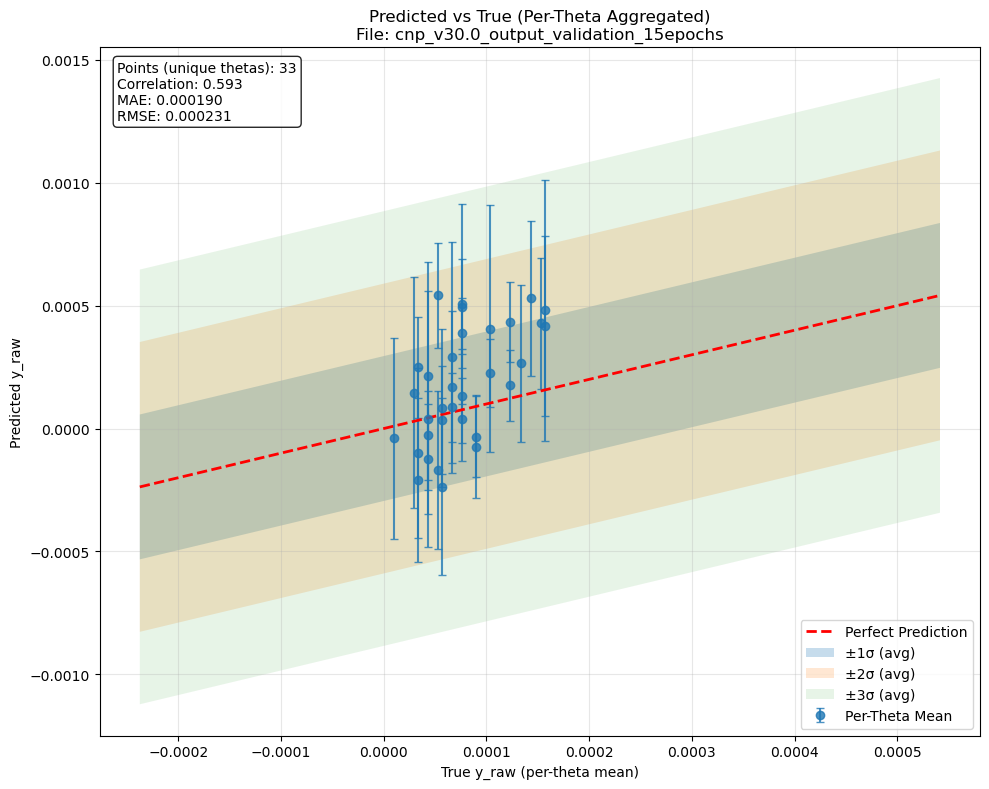


8. Creating plot across all theta values...
    Saved plot: ../xenon/out/mfgp/uncertainty_bands_across_thetas_cnp_v30.0_output_validation_15epochs.png


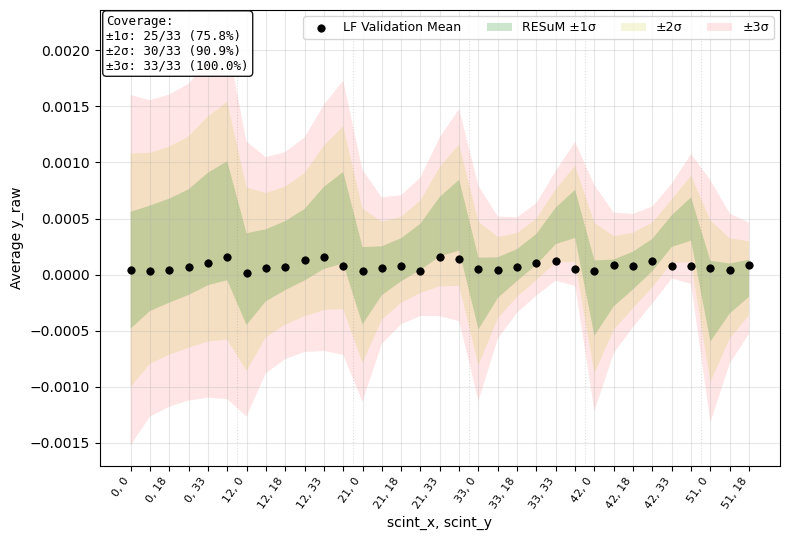


ANALYSIS COMPLETE!
All plots saved to: ../xenon/out/mfgp
Complete. Check your output folder for all saved plots and results.


In [ ]:
current_file_results = analyzer.run_complete_analysis(
    file_patterns=["../xenon/out/cnp/cnp_v30.0_output_validation_15epochs.csv"],  # The file we used for training
    hf_training_data_file="../xenon/out/cnp/cnp_v30.0_output_15epochs.csv",
    fidelity_filter=0.0,     # High fidelity data
    iteration_filter=0,      # First iteration
    plot_individual_groups=True,  # Plot each theta combination
    save_all_plots=True      # 💾 Save ALL generated plots to output folder
    # show_hf_training=True
    # include_hf_training=True (both by default)
)

print("Complete. Check your output folder for all saved plots and results.")